# nn filter state space modeling with variational inference

If you do not have pyro or torch installed, uncomment the following line and run it

In [1]:
#!pip install pyro-ppl
#!pip install torch

In [2]:
import numpy as np 
import random
import matplotlib.pyplot as plt


import pyro
from pyro import optim
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
import pyro.distributions.transforms as Tr
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, MultiStepLR
from pyro.nn import AutoRegressiveNN, PyroModule, PyroSample, PyroParam
from pyro.distributions.transforms import AffineAutoregressive, spline_autoregressive

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.distributions import MultivariateNormal



def set_seed(seed=0):
    torch.manual_seed(seed)
    pyro.set_rng_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

### Coding the generative model

We'll use the same simulator as for Kalman Filter

In [3]:
T_sim = 10 # total time [s]
spring_constant = 10. # spring constant [N/m]
damping_coefficient = .5 # damping coefficient [kg/s]
mass = 1 # mass [kg]
noise_std = 0.5 # standard deviation of noise
dt = 0.01 # time step [s]
z0 = np.array([1., 0.]) # initial state [pos, vel]

state_mat = np.array([[1, dt], 
                      [-dt*(spring_constant/mass), 1. - dt*damping_coefficient/mass]])

def euler_step(z_t: np.ndarray) -> tuple[np.ndarray]:
    """ Euler step for a damped mass-spring system

    Args:
        z_t: State vector [pos, vel]
        dt: time step

    Returns:
        z_new: Updated state vector
        y: Noisy observation
    """
    # state update
    z_new = np.dot(state_mat, z_t)
    # noisy observation
    noise = noise_std * np.random.randn(*z_t.shape)
    y = z_t + noise
    return z_new, y, noise

### Same Data generation  as in Kalman Filter

The following code runs the state-space model  

In [4]:
# Simulate
dim_z = dim_y = 2
t = np.arange(0, T_sim, dt)
z = np.zeros((len(t) + 1, dim_z))
y = np.zeros((len(t), dim_y))
noise = np.zeros((len(t), dim_y))
z[0] = z0
for i in range(1, len(t)+1):
    z[i], y[i-1], noise[i-1] = euler_step(z[i-1])
z = z[:-1]

### Prepare the data to be used in torch 

In [5]:
T = z.shape[0] #number of simulated observations 
z_true = torch.tensor(z).float()
data  = torch.tensor(y).float()  


### A small neural network to model $q(z_t | y_t)$ that is used in the guide-function in the NNKalmanFilter class below 

In [6]:
class IdentityInitEncoder(PyroModule):
    def __init__(self, dim_y, dim_z):
        super().__init__()
        self.fc = PyroModule[nn.Linear](dim_y, 2 * dim_z)

        # Initialize weights to zeros
        nn.init.zeros_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
 
        if dim_y <= dim_z:
            self.fc.weight.data[:dim_y, :dim_y] = torch.eye(dim_y)
        else:
            self.fc.weight.data[:dim_z, :dim_y] = torch.eye(dim_z, dim_y)

        # Bias: loc = 0, scale = exp(-3)
        self.fc.bias.data[:dim_z] = torch.zeros(dim_z)       # loc
        self.fc.bias.data[dim_z:] = torch.full((dim_z,), -3) # log_std

    def forward(self, y_t):
        return self.fc(y_t)  

### Main model with learning the encoder from the observations as a simple MLP layer at time t

In [7]:
# Model definition  
class NNKalmanFilter(PyroModule):
    def __init__(self, dim_z, dim_y, T, hidden_dim=32):
        super().__init__()
        self.dim_z = dim_z
        self.dim_y = dim_y
        self.T = T 
        # PyroParams (registered and optimized automatically)
        self.A = PyroParam(0.9 * torch.eye(dim_z), constraint=constraints.real)
        self.Q = PyroParam(0.05 * torch.eye(dim_z), constraint=constraints.positive_definite)
        self.Q0 = PyroParam(0.05 * torch.eye(dim_z), constraint=constraints.positive_definite)
        self.H = PyroParam(0.05 * torch.eye(dim_y), constraint=constraints.positive_definite)
        self.C = PyroParam(torch.eye(dim_y, dim_z), constraint=constraints.real)

        # Encoder for q(z_t | y_t) 
        self.encoder = IdentityInitEncoder(dim_y, dim_z) 

    def model(self, y=None):
        z_prev = pyro.sample("z_0", dist.MultivariateNormal(torch.zeros(self.dim_z), self.Q0))

        for t in range(self.T):
            mean_z = torch.clamp(self.A @ z_prev, -10.0, 10.0)
            z_t = pyro.sample(f"z_{t+1}", dist.MultivariateNormal(mean_z, self.Q))

            mean_y = self.C @ z_t
            mean_y = torch.nan_to_num(mean_y, nan=0.0, posinf=10.0, neginf=-10.0)
            mean_y = torch.clamp(mean_y, -10.0, 10.0)
  
            obs_dist = dist.MultivariateNormal(mean_y, self.H)

            obs = y[t] if y is not None else None
            pyro.sample(f"y_{t+1}", obs_dist, obs=obs)
                
            z_prev = z_t

    def guide(self, y): 
        
        encoder_out_0 = self.encoder(y[0])
        loc_0, scale_diag_0 = torch.chunk(encoder_out_0, 2, dim=-1)
        scale_diag_0 = torch.nn.functional.softplus(scale_diag_0) + 1e-3
        z_0 = pyro.sample("z_0", dist.MultivariateNormal(loc_0, scale_tril=torch.diag_embed(scale_diag_0)))
        z_prev = z_0

        for t in range(self.T):
            pred_loc = self.A @ z_prev
            encoded = self.encoder(y[t]) 
            delta_loc, scale_diag = torch.chunk(encoded, 2, dim=-1)
            scale_diag = torch.nn.functional.softplus(scale_diag) + 1e-3

            z_t = pyro.sample(
                f"z_{t+1}",
                dist.MultivariateNormal(pred_loc + delta_loc, scale_tril=torch.diag_embed(scale_diag))
            )
            z_prev = z_t

 
 

### The functions to infer the latent variables and reconstruct the observed ones and to plot them

In [8]:
def infer_latents_and_reconstruct(model, y_obs):
    with pyro.poutine.trace() as guide_trace:
        model.guide(y_obs)

    # Reconstruct without conditioning on observations
    model_sample = poutine.replay(model.model, trace=guide_trace.trace)
    sampled_trace = poutine.trace(model_sample).get_trace(None)  # or dummy y_obs if needed

    zs, ys = [], []
    for t in range(model.T):
        z_t = guide_trace.trace.nodes[f"z_{t+1}"]["value"].detach()
        y_t = sampled_trace.nodes[f"y_{t+1}"]["value"].detach()
        zs.append(z_t)
        ys.append(y_t)

    return torch.stack(zs), torch.stack(ys)
 

def plot_latent_and_observed(z, y):
    dim_z = z.shape[1]
    dim_y = y.shape[1]

    plt.figure(figsize=(12, 5))

    for i in range(dim_z):
        plt.subplot(2, dim_z, i+1)
        plt.plot(z[:, i], label=f'z[{i}]')
        plt.title(f"Latent z[{i}]")
        plt.grid(True)
        plt.legend()

    for i in range(dim_y):
        plt.subplot(2, dim_y, dim_z + i + 1)
        plt.plot(y[:, i], label=f'y[{i}]')
        plt.title(f"Observed y[{i}]")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_results(latent_model,data):
    z_inferred, y_recon = infer_latents_and_reconstruct(latent_model,data) 
    c = ["k", "green"]  
    
    # ---- 1. Plot ELBO loss ----
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.title("ELBO Loss over Training");plt.xlabel("Step");plt.ylabel("ELBO")
    plt.grid(True);plt.tight_layout()
    plt.show()
    
    
    # True vs Inferred Latents ----
    plt.figure(figsize=(10, 4))
    for i in range(dim_z):
        plt.subplot(1, dim_z, i+1)
        plt.plot(z_inferred[:, i], "--", label="inferred z", color = c[0], alpha=0.8, linewidth=2)
        plt.plot(z_true[:, i], color = c[1], label="true z", alpha=0.4, linewidth=2)
        plt.title(f"Latent dim {i+1}");plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Reconstruct y_t from inferred z_t ---- 
    
    plt.figure(figsize=(10, 4))
    for i in range(dim_y):
        plt.subplot(1, dim_y, i+1)
        
        plt.plot(y_recon[:, i], "--", color = c[0], alpha=0.8, label="reconstructed y", linewidth=2)
        plt.plot(data[:, i], label="observed y", alpha=0.4, color = c[1], linewidth=2)
        plt.title(f"Output dim {i+1}")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

import pyro.distributions as dist

def predict_future_with_ci(latent_model, y_obs, forecast_steps=5, num_samples=100, ci=0.90):
    """
    Predict future observations with confidence intervals, returning the model's
    own reconstruction (rather than the ground-truth obs).

    Args:
        latent_model: Trained model with .model, .guide, and linear-Gaussian or similar structures
        y_obs (Tensor): Observed sequence, shape [T, dim_y]
        forecast_steps (int): Number of future steps to forecast
        num_samples (int): Monte Carlo samples for uncertainty
        ci (float): Confidence interval level (0.9 for 90%)

    Out:
        z_inferred (Tensor): Guide-inferred latents over observed data [T, dim_z]
        y_recon (Tensor): Model's reconstructed means [T, dim_y]
        y_forecast_mean (Tensor): Forecasted median across num_samples [forecast_steps, dim_y]
        y_forecast_ci (Tensor): Lower & upper confidence bands [forecast_steps, 2, dim_y]
    """
    T = y_obs.shape[0]
    dim_y = y_obs.shape[1]

    # get the latent states from the observed data using the guide
    with poutine.trace() as guide_trace:
        latent_model.guide(y_obs)

    # use the model using the same latent samples
    model_trace = poutine.trace(
        poutine.replay(latent_model.model, trace=guide_trace.trace)
    ).get_trace(y_obs)
 
    # z_inferred: latent states the guide used, shape [T, dim_z]
    z_inferred = torch.stack([
        model_trace.nodes[f"z_{t+1}"]["value"].detach()
        for t in range(T)
    ])

    # y_recon: model-predicted means  
    # Assuming your emission is dist.MultivariateNormal(mean_y, H)
    y_recon = torch.stack([
        model_trace.nodes[f"y_{t+1}"]["fn"].loc.detach()
        for t in range(T)
    ])

    # Get posterior for z_T from the guide
    z_T_node = guide_trace.trace.nodes[f"z_{T}"]
    z_T_loc = z_T_node["fn"].loc.detach()
    z_T_cov = z_T_node["fn"].covariance_matrix.detach()
    mvn_z_T = dist.MultivariateNormal(z_T_loc, z_T_cov)

    # Forecast forward by sampling from the learned model
    forecast_samples = []
    for _ in range(num_samples):
        z_t = mvn_z_T.sample()   # sample from q(z_T | y_obs)
        y_future = []

        for step in range(forecast_steps):
            # Next latent:
            mean_z = latent_model.A @ z_t
            z_t = dist.MultivariateNormal(mean_z, latent_model.Q).sample()

            # Predict next observation:
            mean_y = latent_model.C @ z_t 
            obs_dist = dist.MultivariateNormal(mean_y, latent_model.H)

            y_t = obs_dist.sample()
            y_future.append(y_t)

        forecast_samples.append(torch.stack(y_future))
 
    forecast_tensor = torch.stack(forecast_samples) 
    y_forecast_mean = forecast_tensor.median(dim=0).values

    alpha_lower = (1.0 - ci) / 2
    alpha_upper = (1.0 + ci) / 2
    lower = forecast_tensor.quantile(alpha_lower, dim=0)
    upper = forecast_tensor.quantile(alpha_upper, dim=0)

    y_forecast_ci = torch.stack([lower, upper], dim=1)  

    return z_inferred, y_recon, y_forecast_mean, y_forecast_ci


### Optimization parameters

In [9]:
#number of steps of Variational Inference
num_steps = 200
initial_learning_rate = 0.1
scheduler_params =  {
	"optimizer": torch.optim.Adam,
	"optim_args": {"lr": initial_learning_rate},
	"T_0": 20, "T_mult":1,
	"eta_min": 1e-4
    }

## Optimize the NN filtering model, $q(z_t | y_t)$ on the Gaussian data

Step 0, Loss: 695924.96, LR: 0.10
Step 10, Loss: 15102.44, LR: 0.05
Step 20, Loss: 14929.73, LR: 0.10
Step 30, Loss: 7161.13, LR: 0.05
Step 40, Loss: 5833.72, LR: 0.10
Step 50, Loss: 6006.31, LR: 0.05
Step 60, Loss: 5502.02, LR: 0.10
Step 70, Loss: 5472.52, LR: 0.05
Step 80, Loss: 5336.68, LR: 0.10
Step 90, Loss: 5337.02, LR: 0.05
Step 100, Loss: 5121.10, LR: 0.10
Step 110, Loss: 5241.54, LR: 0.05
Step 120, Loss: 5146.61, LR: 0.10
Step 130, Loss: 5409.17, LR: 0.05
Step 140, Loss: 5205.71, LR: 0.10
Step 150, Loss: 5147.36, LR: 0.05
Step 160, Loss: 5170.35, LR: 0.10
Step 170, Loss: 5617.53, LR: 0.05
Step 180, Loss: 5051.88, LR: 0.10
Step 190, Loss: 5692.24, LR: 0.05


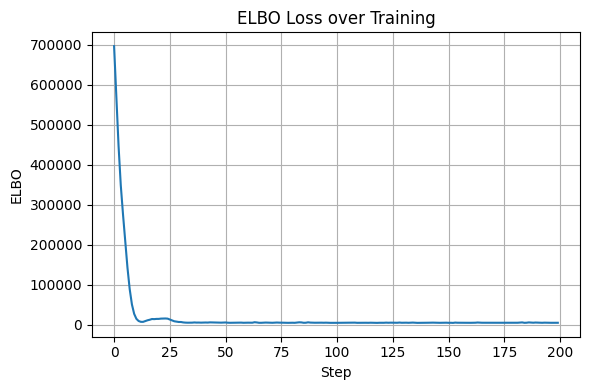

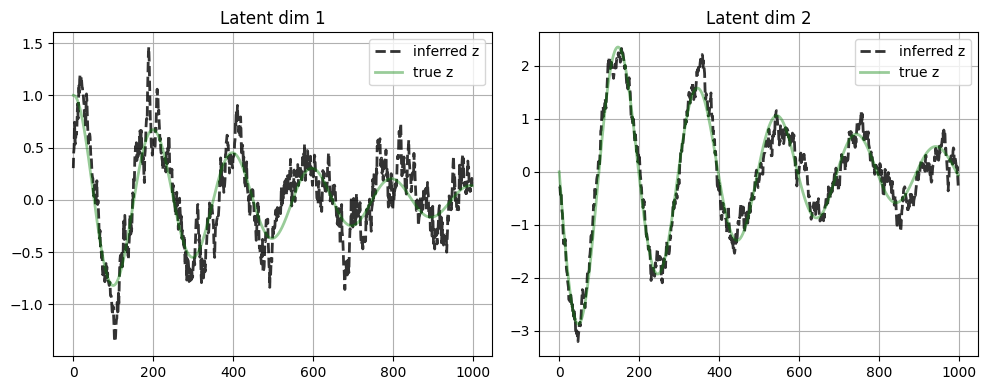

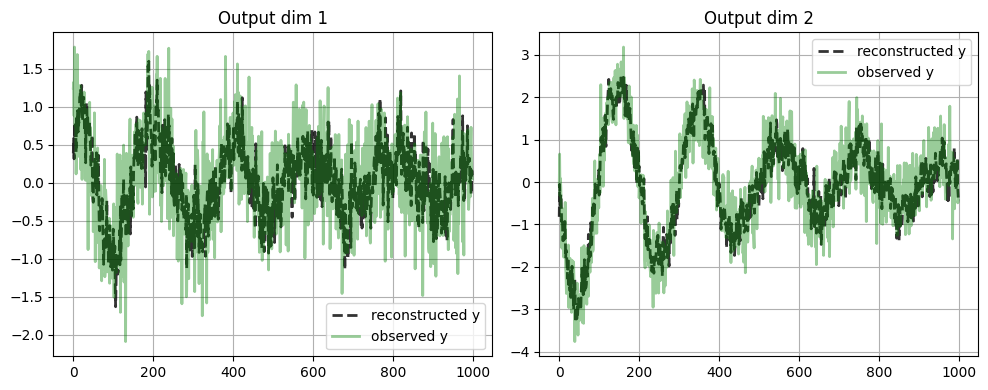

In [10]:

scheduler = optim.CosineAnnealingWarmRestarts(scheduler_params)
 

latent_model = NNKalmanFilter(dim_z, dim_y, T)

svi = SVI(latent_model.model, latent_model.guide, scheduler, loss=Trace_ELBO()) 
# Run inference with scheduler
losses = []  
for step in range(num_steps):
    loss = svi.step(data)
    losses.append(loss)
    scheduler.step(step)
    if step % 10 == 0: 
        optimizer = list(scheduler.optim_objs.values())[0] 
        lr = optimizer.optimizer.param_groups[0]["lr"] 
        print(f"Step {step}, Loss: {loss:.2f}, LR: {lr:.2f}")

plot_results(latent_model,data) 


### Prediction

In [11]:

z_inferred, y_recon, y_forecast_mean, y_forecast_ci = predict_future_with_ci(latent_model, data, forecast_steps=100)


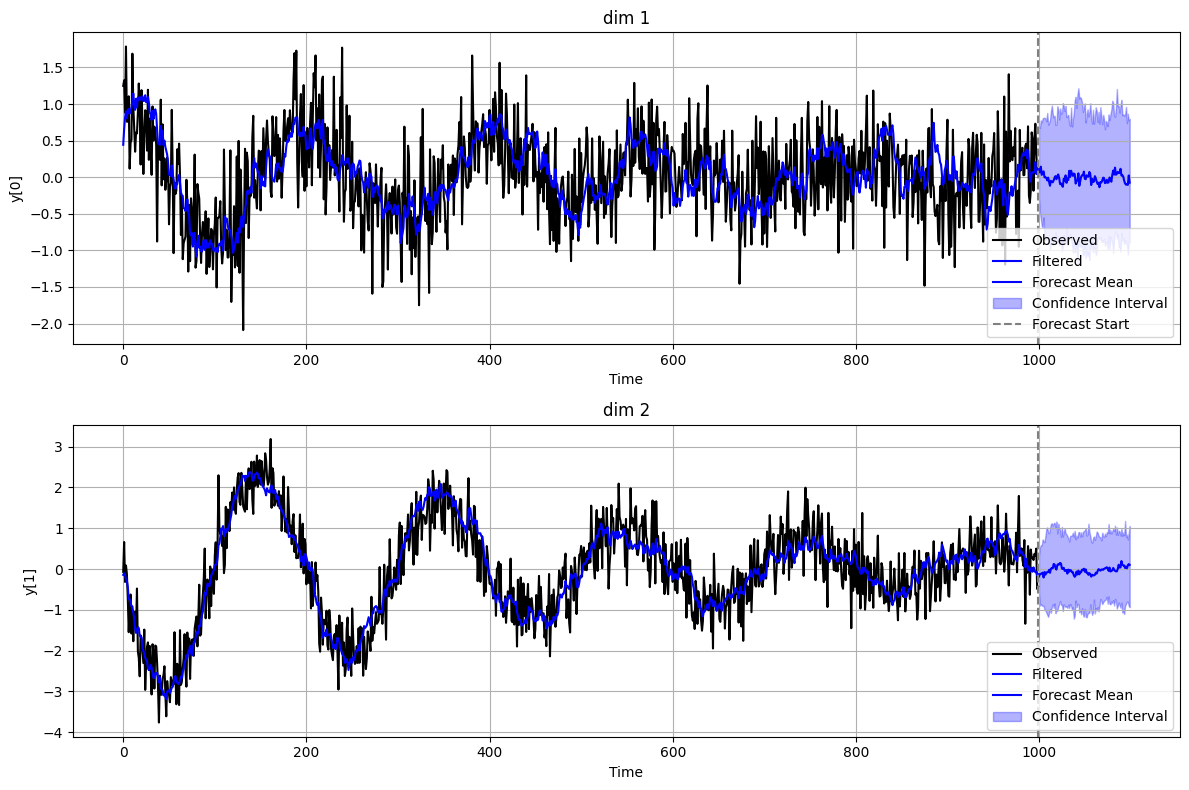

In [15]:
def plot_forecast_with_ci(y_obs, y_recon, y_forecast_mean, y_forecast_ci, title="Forecast with Confidence Intervals"):
    """
    Plot observed and forecasted data with confidence intervals.

    Args:
        y_obs (Tensor): Observed data [T, dim_y]
        y_recon : reconstructed observations 
        y_forecast_mean (Tensor): Predicted mean [forecast_steps, dim_y]
        y_forecast_ci (Tensor): Confidence intervals [forecast_steps, 2, dim_y]
    """
    y_obs = y_obs.detach().cpu()
    y_forecast_mean = y_forecast_mean.detach().cpu()
    y_forecast_ci = y_forecast_ci.detach().cpu()

    T = y_obs.shape[0]
    forecast_steps = y_forecast_mean.shape[0]
    dim_y = y_obs.shape[1]

    plt.figure(figsize=(12, 4 * dim_y))

    for i in range(dim_y):
        plt.subplot(dim_y, 1, i + 1)
        plt.plot(range(T), y_obs[:, i], label="Observed", color='black')
        
        plt.plot(range(T), y_recon[:, i], label="Filtered", color='blue')
        plt.plot(range(T, T + forecast_steps), y_forecast_mean[:, i], label="Forecast Mean", color='blue')

        # Confidence interval shading
        lower = y_forecast_ci[:, 0, i]
        upper = y_forecast_ci[:, 1, i]
        plt.fill_between(range(T, T + forecast_steps), lower, upper, color='blue', alpha=0.3, label="Confidence Interval")

        plt.axvline(T - 1, color='gray', linestyle='--', label="Forecast Start" if i == 0 else "")
        plt.xlabel("Time")
        plt.ylabel(f"y[{i}]")
        plt.title(f"dim {i+1}")
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()


plot_forecast_with_ci(data, y_recon, y_forecast_mean, y_forecast_ci, title="")